# **Lecture5 homework: wind turbulence statistics**

Name: Tang liang

Stuent ID: 24S154108

## **Question**

There are two sets of spatial (vertical z and transverse y) wind velocity time history records, with a duration of 10 minutes and a sampling frequency of 100 Hz (i.e., a time interval of 0.01 s). The data are stored in the windData folder.

### 1 Measurement point coordinates

(1) Z-direction measurement point coordinates
| Num. | 1 | 2 | 3 | 4 | 5 |
| --- | --- | --- | --- | --- | --- |
| x(m) | 0 | 0 | 0 | 0 | 0 |
| y(m) | 0 | 0 | 0 | 0 | 0 |
| z(m) | 10 | 30 | 50 | 70 | 90 |

(2) Y-direction measurement point coordinates
| Num. | 1 | 2 | 3 | 4 | 5 |
| --- | --- | --- | --- | --- | --- |
| x(m) | 0 | 0 | 0 | 0 | 0 |
| y(m) | 0 | 20 | 40 | 60 | 80 |
| z(m) | 50 | 50 | 50 | 50 | 50 |

### 2 Target turbulence characteristics
(1) Mean velocity profile
\begin{gather}
U_{avg}(z) = U_r \left(\frac{z}{z_r}\right)^\alpha \\
U_r=50\, \text{m/s},\ z_r=160\, \text{m},\ \alpha=0.22
\end{gather}

(2) Turbulence intensity profiles
\begin{gather}
I_u(z)=I_{10}\left ( \frac{z}{10}  \right )^{-\alpha}, \ I_v(z)=0.78I_u(z), \ I_w(z)=0.55I_u(z) \\
I_{10}=0.23,\alpha=0.22
\end{gather}

(3) Turbulence integral scale profiles
\begin{gather}
L_u^x(z)=100\left ( \frac{z}{30}  \right )^{0.5}, \ L_v^x(z)=0.5L_u^x(z), \ L_w^x(z)=0.5L_u^x(z) \\
\end{gather}

(4) Von Kármán wind spectra
\begin{gather}
S_u(f)=\frac{4(I_u U_{avg})^2(L_u^x/U_{avg})}{\left [ 1+70.8(fL_u^x/U_{avg})^2 \right ]^{5/6}} \\
S_v(f)=\frac{4(I_v U_{avg})^2(L_v^x/U_{avg})(1+188.4(2fL_v^x/U_{avg})^2)}{\left [ 1+70.8(2fL_v^x/U_{avg})^2 \right ]^{11/6}}  \\
S_w(f)=\frac{4(I_w U_{avg})^2(L_w^x/U_{avg})(1+188.4(2fL_w^x/U_{avg})^2)}{\left [ 1+70.8(2fL_w^x/U_{avg})^2 \right ]^{11/6}} 
\end{gather}

(5) Spatial correlation coefficient in the y-direction proposed by Shiotani  
\begin{gather}
\rho_u^y(r)=e^{-\left | r \right | /L_u^y} \\
\rho_v^y(r)=e^{-\left | r \right | /L_v^y} \\
\rho_w^y(r)=e^{-\left | r \right | /L_w^y} \\
L_u^y=60m,\ L_v^y=50m,\ L_w^y=40m
\end{gather}

### 3 Assignment requirements
Read the wind data in the `windData` folder according to the requirements below, calculate the turbulence characteristics, and plot them (the given target turbulence characteristics should be plotted together).

#### **For the z-direction wind velocity time history, calculate:**

(1) Mean velocity profile (calculate the U-component of velocity)

(2) Turbulence intensity profiles (calculate the fluctuating velocity components u, v, and w)

(3) Wind power spectral density (select one point and calculate the fluctuating velocity components u, v, and w)

(4) Probability density curve (select one point, calculate the fluctuating velocity components u, v, and w, and plot the corresponding normal distribution curve)

#### **For the y-direction wind velocity time history, calculate:**

(1) Spatial correlation coefficient in the y-direction (using the first point as the reference point, calculate the fluctuating velocity components u, v, and w)


## **Answer**

### 1 Statistical results of the z-direction wind velocity time history

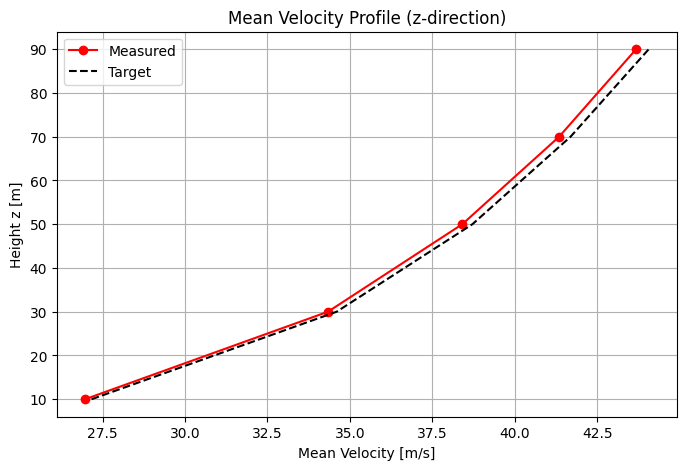

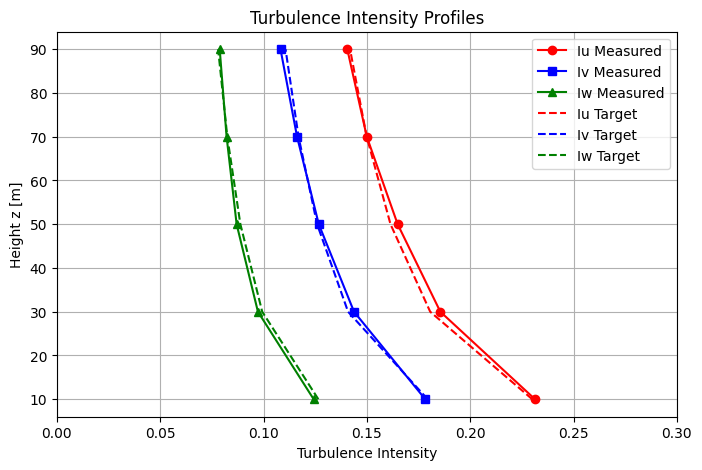

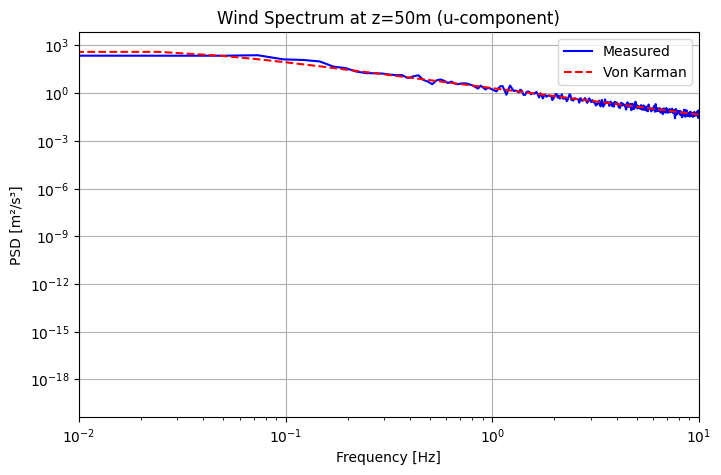

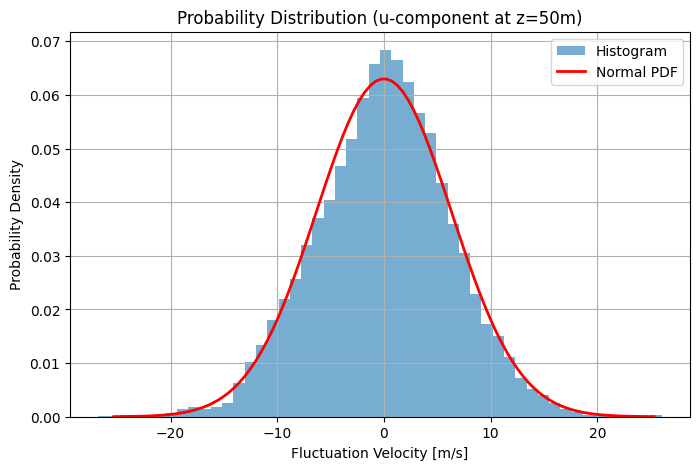

In [12]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, stats
from scipy.fft import fft, fftfreq
from scipy.optimize import curve_fit

# =============================================================================
# 1. z方向风数据分析
# =============================================================================
# 重新加载数据确保变量可用性
simDataPath = './windData/zDirData.mat'
simData = sio.loadmat(simDataPath, squeeze_me=True, struct_as_record=False)
U_z = simData['U']  # 形状应为(5, 60000)
V_z = simData['V']
W_z = simData['W']
Z_coord = simData['Z']
dt = simData['dt']
fs = 1/dt  # 100 Hz
n_points, n_samples = U_z.shape[0], U_z.shape[1]
del simData

# 1.1 平均速度剖面 ------------------------------------------------------------
U_avg = np.mean(U_z, axis=1)  # 各测点U分量时间平均

# 理论值计算
z_ref = 160
U_ref = 50
alpha = 0.22
z_coord = np.array([10,30,50,70,90])
U_target = U_ref * (z_coord/z_ref)**alpha

plt.figure(figsize=(8,5))
plt.plot(U_avg, z_coord, 'ro-', label='Measured')
plt.plot(U_target, z_coord, 'k--', label='Target')
plt.xlabel('Mean Velocity [m/s]'), plt.ylabel('Height z [m]')
plt.title('Mean Velocity Profile (z-direction)')
plt.legend(), plt.grid(True)
plt.show()

# 1.2 湍流强度剖面 -----------------------------------------------------------
# 计算脉动速度
u_prime = U_z - U_avg[:, None]
v_prime = V_z - np.mean(V_z, axis=1)[:, None]
w_prime = W_z - np.mean(W_z, axis=1)[:, None]

Iu = np.std(u_prime, axis=1)/U_avg
Iv = np.std(v_prime, axis=1)/U_avg
Iw = np.std(w_prime, axis=1)/U_avg

# 理论值计算
I10 = 0.23
Iu_target = I10 * (z_coord/10)**(-alpha)
Iv_target = 0.78 * Iu_target
Iw_target = 0.55 * Iu_target

plt.figure(figsize=(8,5))
plt.plot(Iu, z_coord, 'ro-', label='Iu Measured')
plt.plot(Iv, z_coord, 'bs-', label='Iv Measured')
plt.plot(Iw, z_coord, 'g^-', label='Iw Measured')
plt.plot(Iu_target, z_coord, 'r--', label='Iu Target')
plt.plot(Iv_target, z_coord, 'b--', label='Iv Target')
plt.plot(Iw_target, z_coord, 'g--', label='Iw Target')
plt.xlabel('Turbulence Intensity'), plt.ylabel('Height z [m]')
plt.title('Turbulence Intensity Profiles')
plt.legend(), plt.grid(True), plt.xlim(0, 0.3)
plt.show()

# 1.3 风功率谱密度 ----------------------------------------------------------
# 选择第3测点（z=50m）
point_idx = 2  
freq, Pxx = signal.welch(u_prime[point_idx], fs=fs, nperseg=4096)

# 理论谱计算
Lux = 100*(z_coord[point_idx]/30)**0.5
U_avg_point = U_avg[point_idx]
f_n = freq * Lux / U_avg_point
Su_target = (4*(Iu[point_idx]*U_avg_point)**2 * (Lux/U_avg_point)) / (1 + 70.8*(f_n)**2)**(5/6)

plt.figure(figsize=(8,5))
plt.loglog(freq, Pxx, 'b', label='Measured')
plt.loglog(freq, Su_target, 'r--', label='Von Karman')
plt.xlabel('Frequency [Hz]'), plt.ylabel('PSD [m²/s³]')
plt.title('Wind Spectrum at z=50m (u-component)')
plt.legend(), plt.grid(True), plt.xlim(1e-2, 10)
plt.show()

# 1.4 概率密度曲线 ---------------------------------------------------------
# 选择第3测点（z=50m）
u_samples = u_prime[point_idx]

# 计算统计参数
mu, std = np.mean(u_samples), np.std(u_samples)
x = np.linspace(-4*std, 4*std, 100)
pdf_normal = stats.norm.pdf(x, mu, std)

# 绘图
plt.figure(figsize=(8,5))
hist = plt.hist(u_samples, bins=50, density=True, alpha=0.6, label='Histogram')
plt.plot(x, pdf_normal, 'r-', linewidth=2, label='Normal PDF')
plt.xlabel('Fluctuation Velocity [m/s]'), plt.ylabel('Probability Density')
plt.title('Probability Distribution (u-component at z=50m)')
plt.legend(), plt.grid(True)
plt.show()

#### 1.1 Mean velocity profile

#### 1.2 Turbulence intensity profile

#### 1.3 Wind power spectral density

#### 1.4 Probability density curve

### 2 Statistical results of the y-direction wind velocity time history

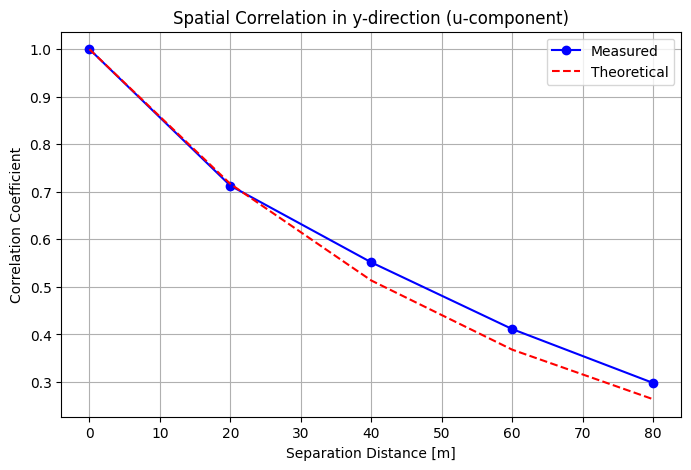

In [13]:
simDataPath = './windData/yDirData.mat'
simData = sio.loadmat(simDataPath, squeeze_me=True, struct_as_record=False)
U_y = simData['U']  # 形状应为(5, 60000)
Y_coord = simData['Y']
del simData

# 2.1 空间相关系数 ----------------------------------------------------------
# 计算脉动速度
u_prime_y = U_y - np.mean(U_y, axis=1)[:, None]

# 参考点（第一个测点）
ref_point = 0
r = np.abs(Y_coord - Y_coord[ref_point])  # 距离差

# 计算相关系数
corr_coeffs = []
for i in range(len(Y_coord)):
    corr = np.corrcoef(u_prime_y[ref_point], u_prime_y[i])[0,1]
    corr_coeffs.append(corr)

# 理论模型
Luy = 60  # 根据题目给定参数
rho_target = np.exp(-r/Luy)

plt.figure(figsize=(8,5))
plt.plot(r, corr_coeffs, 'bo-', label='Measured')
plt.plot(r, rho_target, 'r--', label='Theoretical')
plt.xlabel('Separation Distance [m]'), plt.ylabel('Correlation Coefficient')
plt.title('Spatial Correlation in y-direction (u-component)')
plt.legend(), plt.grid(True)
plt.show()

#### 2.1 Spatial correlation coefficient in y direction